# ADU Classifier

## Project Description

In the scope of the DARGMINTS project, an annotation project was carried out which consisted of annotating argumentation structures in opinion articles published in the Público newspaper. The annotation included several layers:

- Selecting text spans that are taken to have an argumentative role (either as premises or conclusions of arguments) -- these are Argumentative Discourse Units (ADU).
- Connecting such ADUs through support or attack relations.
- Classifying the propositional content of ADUs as propositions of fact, propositions of value, or propositions of policy; within propositions of value, distinguish between those with a positive (+) or negative (-) connotation.

In a proposition of fact, the content corresponds to a piece of information that can be checked for truthness. This does not usually happen with propositions of value, which denote value judgments with a strong subjective nature; often, they also have a (positive or negative) polarity attached. A proposition of policy prescribes or suggests a certain line of action, often mentioning the agents or entities that are capable of carrying out such policies.

The aim of this assignment is to build a classifier of types of ADUs, thus focusing on the last annotation step described above. For that, you have access to two different files:

- A file containing the content of each annotated ADU span and its 5-class classification: Value, Value(+), Value(-), Fact, or Policy. For each ADU, we also know the annotator and the document from which it has been taken.
- A file containing details for each opinion article that has been annotated, including the full article content.
Besides ADU contents, you can make use of any contextual information provided in the corresponding opinion article.

Each opinion article has been annotated by 3 different annotators. For that reason, you will find in the ADU file an indication of which annotator has obtained the ADU. It may happen that the same ADU has been annotated by more than one annotator. When that is the case, they do not necessarily agree on the type of proposition.

How good a classifier (or set of classifiers) can you get? Don't forget to properly split the dataset in a sensible manner, so that you have a proper test set. Start by obtaining an arbitrary baseline, against which you can then compare your improvements.

## Developed ADU Classifier

### Datasets 
Let's start by opening the datasets and analyzing the structure of the available data.

In [89]:
# importing necessary libraries
import numpy as np 
import pandas as pd
import unidecode
import seaborn as sb
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from tabulate import tabulate


In [8]:
# reading the datasets
articles = pd.read_excel('./OpArticles/OpArticles.xlsx')
adus = pd.read_excel('./OpArticles/OpArticles_ADUs.xlsx')


In [12]:
#Articles
articles.head()

,article_id,title,authors,body,meta_description,topics,keywords,publish_date,url_canonical
0,5d04a31b896a7fea069ef06f,"Pouco pão e muito circo, morte e bocejo",['José Vítor Malheiros'],"O poeta espanhol António Machado escrevia, uns...","É tudo cómico na FIFA, porque todos os dias a ...",Sports,"['Brasil', 'Campeonato do Mundo', 'Desporto', ...",2014-06-17 00:16:00,https://www.publico.pt/2014/06/17/desporto/opi...
1,5d04a3fc896a7fea069f0717,Portugal nos Mundiais de Futebol de 2010 e 2014,['Rui J. Baptista'],“O mais excelente quadro posto a uma luz logo ...,Deve ser evidenciado o clima favorável criado ...,Sports,"['Brasil', 'Campeonato do Mundo', 'Coreia do N...",2014-07-05 02:46:00,https://www.publico.pt/2014/07/05/desporto/opi...
2,5d04a455896a7fea069f07ab,"Futebol, guerra, religião",['Fernando Belo'],1. As sociedades humanas parecem ser regidas p...,O futebol parece ser um sucedâneo quer da lei ...,Sports,"['A guerra na Síria', 'Desporto', 'Futebol', '...",2014-07-12 16:05:33,https://www.publico.pt/2014/07/12/desporto/opi...
3,5d04a52f896a7fea069f0921,As razões do Qatar para acolher o Mundial em 2022,['Hamad bin Khalifa bin Ahmad Al Thani'],Este foi um Mundial incrível. Vimos actuações ...,Queremos cooperar plenamente com a investigaçã...,Sports,"['Desporto', 'FIFA', 'Futebol', 'Mundial de fu...",2014-07-27 02:00:00,https://www.publico.pt/2014/07/27/desporto/opi...
4,5d04a8d7896a7fea069f6997,A política no campo de futebol,['Carlos Nolasco'],O futebol sempre foi um jogo aparentemente sim...,Retirar a expressão política do futebol é reti...,Sports,"['Albânia', 'Campeonato da Europa', 'Desporto'...",2014-10-23 00:16:00,https://www.publico.pt/2014/10/23/desporto/opi...


In [16]:
#ADUs
adus.head()

,article_id,annotator,node,ranges,tokens,label
0,5d04a31b896a7fea069ef06f,A,0,"[[2516, 2556]]",O facto não é apenas fruto da ignorância,Value
1,5d04a31b896a7fea069ef06f,A,1,"[[2568, 2806]]",havia no seu humor mais jornalismo (mais inves...,Value
2,5d04a31b896a7fea069ef06f,A,3,"[[3169, 3190]]",É tudo cómico na FIFA,Value
3,5d04a31b896a7fea069ef06f,A,4,"[[3198, 3285]]",o que todos nós permitimos que esta organizaçã...,Value
4,5d04a31b896a7fea069ef06f,A,6,"[[4257, 4296]]",não nos fazem rir à custa dos poderosos,Value


## Data Analysis

Number of ADUs of each annotator:

In [20]:
adus.value_counts("annotator")

annotator
B    5226
C    4111
D    4071
A    3335
dtype: int64

Number of occurences of each label:

In [24]:
adus.value_counts("label")

label
Value       8102
Fact        3663
Value(-)    2900
Value(+)    1411
Policy       667
dtype: int64

Get all the ADUs that were found by more than one annotator:

In [28]:
repADUs=adus[adus.duplicated(['ranges', 'article_id'], keep=False)].sort_values(by=['ranges'])
repADUs

,article_id,annotator,node,ranges,tokens,label
3428,5cf47371896a7fea06009c23,B,0,"[[0, 101]]",A fase da desconfiança em relação à sobrevivên...,Value
3444,5cf47371896a7fea06009c23,C,0,"[[0, 101]]",A fase da desconfiança em relação à sobrevivên...,Value
3426,5cf47371896a7fea06009c23,A,6,"[[0, 101]]",A fase da desconfiança em relação à sobrevivên...,Value
1654,5d04c505896a7fea06a0fabc,A,0,"[[0, 104]]",Em dezembro do ano passado Fernando Medina ava...,Value
1669,5d04c505896a7fea06a0fabc,B,0,"[[0, 104]]",Em dezembro do ano passado Fernando Medina ava...,Fact
...,...,...,...,...,...,...
9126,5cf462de896a7fea06ff9495,C,3,"[[998, 1032]]",a violência agravou-se brutalmente,Value(-)
9146,5cf462de896a7fea06ff9495,D,6,"[[998, 1032]]",a violência agravou-se brutalmente,Fact
15430,5cde31c4896a7fea063370a5,A,7,"[[998, 1044]]",os governos desconhecem a realidade desportiva,Value(-)
15449,5cde31c4896a7fea063370a5,B,7,"[[998, 1044]]",os governos desconhecem a realidade desportiva,Value


Get all the rows where the same ADUs got a different label:

In [32]:
difADUs=repADUs.drop_duplicates(subset=['article_id','ranges','label']).sort_values(by=['ranges'])
difADUs

,article_id,annotator,node,ranges,tokens,label
3428,5cf47371896a7fea06009c23,B,0,"[[0, 101]]",A fase da desconfiança em relação à sobrevivên...,Value
1654,5d04c505896a7fea06a0fabc,A,0,"[[0, 104]]",Em dezembro do ano passado Fernando Medina ava...,Value
1669,5d04c505896a7fea06a0fabc,B,0,"[[0, 104]]",Em dezembro do ano passado Fernando Medina ava...,Fact
6587,5cf4675d896a7fea06ffe0fe,C,0,"[[0, 105]]",Já lá vão uns valentes séculos desde que o Mar...,Fact
4654,5cf47065896a7fea060065b5,C,1,"[[0, 108]]",As instituições de ensino superior portuguesas...,Value(+)
...,...,...,...,...,...,...
5481,5cf46c00896a7fea06002671,C,13,"[[997, 1072]]",que disponibilize os resultados da investigaçã...,Policy
9104,5cf462de896a7fea06ff9495,B,5,"[[998, 1032]]",a violência agravou-se brutalmente,Value(-)
9146,5cf462de896a7fea06ff9495,D,6,"[[998, 1032]]",a violência agravou-se brutalmente,Fact
15430,5cde31c4896a7fea063370a5,A,7,"[[998, 1044]]",os governos desconhecem a realidade desportiva,Value(-)


Get all tokens in which there were different labels assigned:

In [36]:
difADUs[difADUs.duplicated(['article_id','ranges'], keep=False)].sort_values(by=['ranges'])


,article_id,annotator,node,ranges,tokens,label
1654,5d04c505896a7fea06a0fabc,A,0,"[[0, 104]]",Em dezembro do ano passado Fernando Medina ava...,Value
1669,5d04c505896a7fea06a0fabc,B,0,"[[0, 104]]",Em dezembro do ano passado Fernando Medina ava...,Fact
4654,5cf47065896a7fea060065b5,C,1,"[[0, 108]]",As instituições de ensino superior portuguesas...,Value(+)
4691,5cf47065896a7fea060065b5,D,0,"[[0, 108]]",As instituições de ensino superior portuguesas...,Value
15413,5cddb333896a7fea062e8b18,B,0,"[[0, 109]]",Uma olimpíada da ciência da União Europeia ser...,Value(+)
...,...,...,...,...,...,...
5481,5cf46c00896a7fea06002671,C,13,"[[997, 1072]]",que disponibilize os resultados da investigaçã...,Policy
9104,5cf462de896a7fea06ff9495,B,5,"[[998, 1032]]",a violência agravou-se brutalmente,Value(-)
9146,5cf462de896a7fea06ff9495,D,6,"[[998, 1032]]",a violência agravou-se brutalmente,Fact
15430,5cde31c4896a7fea063370a5,A,7,"[[998, 1044]]",os governos desconhecem a realidade desportiva,Value(-)


### Split the dataset by annotators

In [40]:
dfA= adus.loc[adus['annotator'] == 'A']
dfB= adus.loc[adus['annotator'] == 'B']
dfC= adus.loc[adus['annotator'] == 'C']
dfD= adus.loc[adus['annotator'] == 'D']

### Get only the token and label collumns

In [44]:
def getTokenLabelcollumns(df):
    return(df[['tokens', 'label']])

## Baseline

Here we will define some standard helper functions that will be used throughout this notebook.  

### Building a standard corpus

With this function, by giving a stemmer and a dataframe, a corpus is built, applying some simple cleaning tasks, such as removing stop words and upper cases. One thing to have in mind is that the dataset is in portuguese, the standard english versions need to be changed to portuguese.

In [48]:
def buildCorpus(df):
    df=df[['tokens', 'label']]
    corpus = []

    stemmer= SnowballStemmer('portuguese')
    for i in df.itertuples():
        # get token and remove non alpha chars
        token= unidecode.unidecode(i.tokens)
        token = re.sub('[^a-zA-Z]', ' ', token)
        # to lower-case
        token =  token.lower()
        # split into tokens, apply stemming and remove stop words
        token = ' '.join([stemmer.stem(w) for w in token.split() if not w in set(stopwords.words('portuguese'))])
        corpus.append(token)
    return corpus

In [52]:
corpusA= buildCorpus(dfA)

### Build bag of words Model

In [56]:
def bagOfWords(corpus):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus).toarray()
    return X

### Split the dataset in train and test

In [60]:
X=bagOfWords(corpusA)
y=dfA['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2668, 5246) (2668,)
(667, 5246) (667,)


### Making the Classifier
For the baseline, let's try Naive Bayes

In [72]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

### Evaluating the Results

Report:
              precision    recall  f1-score   support

        Fact       0.47      0.25      0.33       140
      Policy       0.00      0.00      0.00        15
       Value       0.63      0.90      0.74       398
    Value(+)       0.00      0.00      0.00        31
    Value(-)       0.29      0.08      0.13        83

    accuracy                           0.60       667
   macro avg       0.28      0.25      0.24       667
weighted avg       0.51      0.60      0.53       667




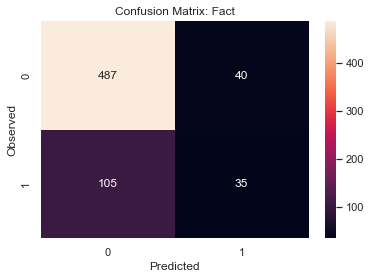

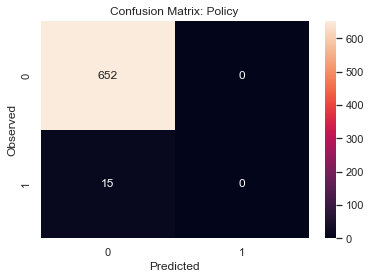

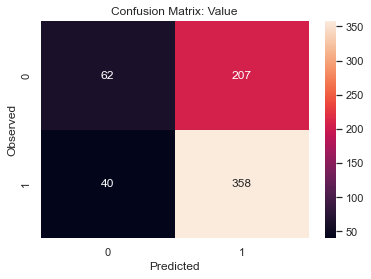

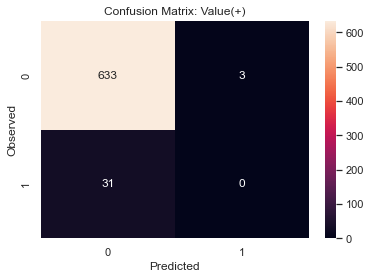

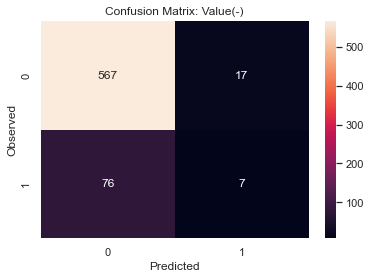

In [80]:
def evaluation(pred):
    report = classification_report(y_test, pred, output_dict=True,zero_division= 0)

    print(f"Report:\n{classification_report(y_test, pred,zero_division= 0)}\n")

    sb.set(font_scale=1.0)
    labels=["Fact", "Policy", "Value","Value(+)","Value(-)"];
    i=0;
    mcm = multilabel_confusion_matrix(y_test, pred,labels=["Fact", "Policy", "Value","Value(+)","Value(-)"])
    for cm in mcm:
        ax = plt.subplot()
        sb.heatmap(cm, annot=True, ax=ax, fmt="g")

        ax.set_xlabel('Predicted');
        ax.set_ylabel('Observed');
        ax.set_title(f"Confusion Matrix: {labels[i]}");
        plt.show()
        i+=1;

evaluation(pred)

### Trying cross validation

In [96]:

scores = cross_validate(clf, X, y, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], return_train_score=True)

labels=["", "Fact", "Policy", "Value","Value(+)","Value(-)"];

#TODO make visualization pretty uwu

#TODO flavia
#### Other classifiers

Try out using other classifiers, such as:
- *Logistic Regression*, through scikit-learn's [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class.
- *Decision Tree*, through scikit-learn's [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class. This model always assigns a probability of 1 to one of the classes.
- *Random Forest*, through scikit-learn's [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class.
- *Support Vector Machines (SVM)*, through scikit-learn's [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) class. The SVM model also allows you to get probabilities, but for that you need to use the *probability=True* parameter setting in its constructor.
- *Perceptron*, through scikit-learn's [Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) class. This model does not allow you to get probabilities.
- *eXtreme Gradient Boosting*, through [XGBoost](https://xgboost.readthedocs.io/en/stable/).

#TODO 
- more classifiers
- more metrics

#TODO

- separar por anotadores
- analisar os resultados dos anotadores uns contra os outros
- 